Using Goemans-Williamson algorithm when determining haplotype memberships.

In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from os import path
from copy import deepcopy
from tqdm import tqdm

import logging
from typing import Any
from nptyping import NDArray

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import cvxpy as cp
from matplotlib import pyplot as plt
%matplotlib inline

from read_embeddings import save_ckp, load_ckp, MyFilter, \
    ReadAE, SNVMatrixDataset, learn_embed
from ScheduleOptim import ScheduledOptim
from helper import read_true_hap, compute_cpr

In [136]:
class CorrTransformer(nn.Module):
    def __init__(self, d_model: int=512, d_qk: int=None):
        super().__init__()
        d_ff = 4*d_model  # Dimension of intermediate feedforward layer
        n_head = 4  # Number of attention heads
        if d_qk is None:
            d_qk = int(d_model//n_head)  # Dim of query and key vectors in last attn layer

        self.d_model = d_model
        self.d_qk = d_qk
        encoderLayer = nn.TransformerEncoderLayer(d_model, n_head, d_ff,
                                                  batch_first=True)
        self.encoder = nn.TransformerEncoder(encoderLayer, num_layers=2)
        self.attn_lastq = nn.Linear(d_model, d_qk)
        self.attn_lastk = nn.Linear(d_model, d_qk)
        

    def forward(self, x):
        x_enc = self.encoder(x)
        lastq = self.attn_lastq(x_enc)
        lastk = self.attn_lastk(x_enc)
        Z = F.softmax(torch.matmul(lastq, lastk.transpose(1,2))
                      /np.sqrt(self.d_qk), dim=-1)
        return 2*(1 - 0.5*(Z + Z.transpose(1,2))) - 1

In [137]:
def det_memhap(SNVdataset: SNVMatrixDataset,
               ae: ReadAE, xformer: CorrTransformer
               ):

    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    W_full = W_full[0]  # Removing dummy dimension

    # Solving SDP relaxation using gradient descent
    sval_thr = 1e-3  # eps_th in SDHap
    change_thr = 1e-4  # eps_tol in SDHap"
    V = np.random.randn(m, 2)
    V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization
    
    col_V = np.shape(V)[1]
    rank_V = 1
    upd = True  # Set to false when convergence is achieved
    obj_curr = np.inf
    
#     print('Weight matrix: ', W_full)
#     print("Initial V: ", V)
    while upd:
        for i in range(m):
            V[i] = -1*W_full[i] @ V
            V[i] = V[i]/np.linalg.norm(V[i])
        rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
        if(rank_V == col_V):  # V is full column rank
            col_V = col_V + 1
            rand_col = np.random.rand(m)
            V = np.append(V, 0.01*rand_col[:,np.newaxis],
                          axis=1)
            V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization
        
        obj_prev = obj_curr
        obj_curr = np.trace(W_full @ V @ V.T)
#         print("k = ", rank_V, ", r = ", col_V)
#         print("Prev obj = ", obj_prev, ", new obj = ", obj_curr)
#         print("Percentage drop in objective value = ", 1 - obj_curr/obj_prev)
        upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

    # Randomized projection
    num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
    round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
    round_obj = np.zeros(num_rounds)  # ojective for each round
    for i in range(num_rounds):
        unit_vec = np.random.randn(col_V)
#         print(i, unit_vec, np.sum(V @ unit_vec > 0))
        x = -1*np.ones(m, dtype=np.float32)
        x[np.where(V @ unit_vec > 0)] = 1
        
        round_x[:, i] = x
        round_obj[i] = np.dot(x, W_full @ x)

    return round_x[:, np.argmin(round_obj)]

In [138]:
# get the ACGT statistics of a read matrix
def ACGT_count(submatrix: NDArray[(Any, Any), int]):
    out = np.zeros((submatrix.shape[1], 4))
    for i in range(4):
        out[:, i] = (submatrix == (i + 1)).sum(axis = 0)

    return out 

In [139]:
def origin2hap(SNV_matrix: NDArray[(Any, Any), int], origin: NDArray[int],
              num_hap: int=2) -> NDArray[(Any, Any), int]:    
    """
    SNV_matrix:
        Full read-SNV matrix
    origin: 
        Specifies origin of each read by an int from (0, 1, ..., num_hap-1)
        
    Returns
        matrix of haplotypes (haplotypes x SNPs)
    """
    
    origin_val = np.unique(origin)
    accepted_val = np.arange(num_hap)
    if np.any(np.intersect1d(origin_val, accepted_val) != origin_val):
    	raise ValueError("Invalid origin values passed as argument.")

    hap_matrix = np.zeros((num_hap, SNV_matrix.shape[1]), dtype=int)
    ACGTcount = ACGT_count(SNV_matrix)  # Stats of entire read matrix
    for h in range(num_hap):
        reads_h = SNV_matrix[origin == h]  # Reads attributed to haplotype i
        h_stats = np.zeros((SNV_matrix.shape[1], 4))
        
        if len(reads_h) != 0:
            h_stats = ACGT_count(reads_h) # ACGT statistics of a single nucleotide position
        hap_matrix[h, :] = np.argmax(h_stats, axis = 1) + 1  # Most commonly occuring base at each pos  
        
        uncov_pos = np.where(np.sum(h_stats, axis = 1) == 0)[0]  # Positions uncovered by reads
        for j in range(len(uncov_pos)):  # if not covered, select the most doninant one based on 'ACGTcount'  
            base_max = np.flatnonzero(ACGTcount[uncov_pos[j], :] == np.amax(ACGTcount[uncov_pos[j], :])) + 1
            if len(base_max) == 1:  # Single dominant base
                hap_matrix[h, uncov_pos[j]] == base_max[0]
            else:  # Choose one of the dominant bases at random
                hap_matrix[h, uncov_pos[j]] = np.random.choice(base_max)

    return hap_matrix

In [140]:
def hamming_distance(read, haplo):
    return sum((haplo - read)[read != 0] != 0)

In [141]:
def MEC(SNV_matrix: NDArray[(Any, Any), int],
        hap_matrix: NDArray[(Any, Any), int]) -> float:  # Compute MEC score
    res = 0
    
    for SNV_read in SNV_matrix:
        dis = [hamming_distance(SNV_read, hap) for j, hap in enumerate(hap_matrix)]
        res = res + min(dis)
        
    return res

In [142]:
def refine(hap_matrix: NDArray[(Any, Any), int],
           SNV_matrix: NDArray[(Any, Any), int],
           verbose=False
          ) -> NDArray[(Any, Any), int]: 
    """
    This function greedily refines the haplotype matrix by iterating through the
    SNPs and flipping the haplotype bases. The flip is accepted (greedily) if it
    improves the MEC score.

    """

    hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
    mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

    hap_matrix_new = deepcopy(hap_matrix)
    while True:
        mec_startiter = mec_curr
        for j in range(np.shape(hap_matrix)[1]):
            hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
            mec_new = MEC(SNV_matrix, hap_matrix_new)
            if mec_new < mec_curr:  # Update refined solution
                mec_curr = mec_new
                hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
            else:  # Reverse base flip
                hap_matrix_new[:,j] = hap_matrix[:,j]
        if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
            return hap_matrix_greedy
        elif verbose:
            print("MEC improved from %i to %i"%(mec_startiter, mec_curr))

Set up dataloader and hyperparameters.

In [143]:
# datapath = 'Simulated_data/diploid/cov15/sample1/simu_erro1_K2_cov5'\
#             '_l5000_iter_1_SNV_matrix.txt'
datapath = 'generate_data/haptest/haptest_SNV_matrix.txt'
SNVdata = SNVMatrixDataset(datapath)
SNV_matrix = np.loadtxt(datapath, dtype=int)
nSNP = SNV_matrix.shape[1] # Number of SNVs
num_read = len(SNVdata)  # Number of reads
batch_size = int(np.ceil(num_read/20))
d_model = 128  # Size of embeddings

dataloader = DataLoader(SNVdata, batch_size=batch_size,
                        shuffle=True, num_workers=0)


Read in ground truth.

In [144]:
# gt_file = "Simulated_data/diploid/cov15/sample1/combined.fa"
# pos_file = "Simulated_data/diploid/cov15/sample1/"\
#             "simu_erro1_K2_cov5_l5000_iter_1_SNV_pos.txt"
gt_file = 'generate_data/haptest/combined.fa'
pos_file = 'generate_data/haptest/haptest_SNV_pos.txt'
true_haplo = read_true_hap(gt_file, pos_file)

Load autoencoder for read embeddings. If the weights aren't stored in savefile, train autoencoder for said embeddings.

In [145]:
savefile="read_AE"
embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)

# if path.isfile(savefile):
#     embedAE = ReadAE(nSNP, latent_dim=d_model)
#     embed_optimizer = optim.Adam(embedAE.parameters(), lr=1e-2)
#     embedAE, embed_optimizer, _ = load_ckp(savefile, embedAE, embed_optimizer)
# else:
#     embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.54s/it]


Setting up transformer with hyperparameters and training it.

In [146]:
corr_xformer = CorrTransformer(d_model, d_model//2)  # Transformer
num_epoch = 150
warmup_steps = 10  # Number of steps to linear increase learning rate

xform_optimizer = ScheduledOptim(
    optim.Adam(corr_xformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        lr_mul=0.1, d_model=d_model, n_warmup_steps=warmup_steps) # Optimizer with customized schedule

In [147]:
def xformer_loss(xformer_output: torch.Tensor,
                 origin: torch.Tensor) -> float:
    res = torch.matmul(origin, torch.matmul(xformer_output, origin))
    return res

In [148]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler('xformer_train.log')
c_handler.setLevel(logging.WARNING)
f_handler.setLevel(logging.INFO)
f_handler.addFilter(MyFilter(logging.INFO))

# Create formatters and add it to handlers
c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)

In [149]:
xform_train_loss_arr = []
mec = []
cpr = []
xformer_savefile = "corr_xformer"

hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
mec.append(MEC(SNV_matrix, hap_matrix))
cpr.append(compute_cpr(hap_matrix, true_haplo))

for epoch in range(num_epoch):
    xform_train_loss = 0
    for batch_data, batch_idx in dataloader:
        xform_optimizer.zero_grad()
        embed, recon = embedAE(batch_data)
        Z_batch = corr_xformer(embed[None,:])
        xform_loss = xformer_loss(Z_batch[0],
                                  torch.from_numpy(hap_origin[batch_idx]))
        xform_loss.backward()
        xform_optimizer.step_and_update_lr()
        xform_train_loss += xform_loss.item()
    
    xform_train_loss = xform_train_loss / len(dataloader)
    xform_train_loss_arr.append(xform_train_loss)
    
    hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
    hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2)
#     hap_matrix = refine(hap_matrix, SNV_matrix)
    mec.append(MEC(SNV_matrix, hap_matrix))
    cpr.append(compute_cpr(hap_matrix, true_haplo))

    # Display epoch training loss
    logger.info("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    print("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    if xformer_savefile and (epoch % 10 == 0):
        checkpoint = {
        'epoch': epoch + 1,
        'state_dict': embedAE.state_dict(),
#         'optimizer': xform_optimizer.state_dict(),
        }
        save_ckp(checkpoint, xformer_savefile)


epoch : 1/150, loss = 48.17
epoch : 2/150, loss = 46.43
epoch : 3/150, loss = 89.10
epoch : 4/150, loss = 53.52
epoch : 5/150, loss = 36.41
epoch : 6/150, loss = 68.69
epoch : 7/150, loss = 54.34
epoch : 8/150, loss = 87.30
epoch : 9/150, loss = 42.51
epoch : 10/150, loss = 55.64
epoch : 11/150, loss = 28.30
epoch : 12/150, loss = 76.12
epoch : 13/150, loss = 63.78
epoch : 14/150, loss = 79.83
epoch : 15/150, loss = 50.55
epoch : 16/150, loss = 37.27
epoch : 17/150, loss = 36.64
epoch : 18/150, loss = 38.42
epoch : 19/150, loss = 37.84
epoch : 20/150, loss = 55.74
epoch : 21/150, loss = 39.29
epoch : 22/150, loss = 55.33
epoch : 23/150, loss = 88.35
epoch : 24/150, loss = 50.35
epoch : 25/150, loss = 58.28
epoch : 26/150, loss = 68.33
epoch : 27/150, loss = 85.71
epoch : 28/150, loss = 38.56
epoch : 29/150, loss = 34.53
epoch : 30/150, loss = 30.97
epoch : 31/150, loss = 70.85
epoch : 32/150, loss = 29.06
epoch : 33/150, loss = 67.81
epoch : 34/150, loss = 64.85
epoch : 35/150, loss = 

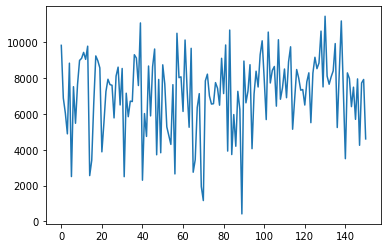

In [150]:
plt.plot(mec)

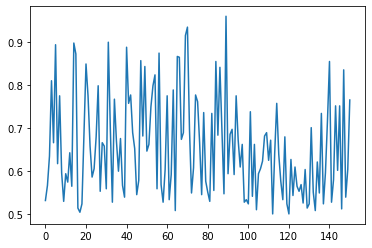

In [151]:
plt.plot(cpr)

[[ 1.         -0.83792739]
 [-0.83792739  1.        ]]
[(418, 0.9609375), (1163, 0.935546875), (1945, 0.916015625)]


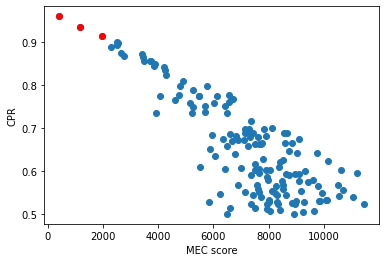

In [152]:
plt.scatter(mec, cpr)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_best = np.argsort(mec)[:3]
plt.scatter(np.array(mec)[idx_best], np.array(cpr)[idx_best], color='red')

print(np.corrcoef(mec, cpr))
print(list(zip(np.array(mec)[idx_best], np.array(cpr)[idx_best])))

### Examining learned W

In [168]:
m = len(SNVdata)
dataloader_full = DataLoader(SNVdata, batch_size=m,
                            num_workers=0)
for i, (data, idx) in enumerate(dataloader_full):
    SNV_onehot = data
embed, _ = embedAE(SNV_onehot)  # Read embeddings
W_full = corr_xformer(embed[None,:]).detach().numpy()  # Converting to numpy
print(np.diag(W_full[0])[np.diag(W_full[0]) > 0])
print(np.amax(np.diag(W_full[0])))
print(np.diag(W_full[0])

[0.00918126 0.21780777 0.04085946 0.19864082 0.03990209 0.38723636
 0.35141277 0.49786174 0.0745486  0.1934433  0.73388386 0.01268351
 0.63235795 0.04365861]
0.73388386


### SDHap

In [20]:
W = squareform(pdist(SNV_matrix, hamming_distance))
m = np.shape(W)[0]

In [57]:
# Solving SDP relaxation using gradient descent
sval_thr = 1e-3  # eps_th in SDHap
change_thr = 1e-5  # eps_tol in SDHap
V = np.random.randn(m, 2)
V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

col_V = np.shape(V)[1]
rank_V = 1
upd = True  # Set to false when convergence is achieved
obj_curr = np.inf

print('Weight matrix: ', W)
print("Initial V: ", V[:10])
while upd:
    for i in range(m):
        V[i] = -1*W[i] @ V
#         print("After multiplication ", i, V[i])
        V[i] = V[i]/np.linalg.norm(V[i])
#     print(V[:10])
#         print('Singular values: ', np.linalg.svd(V, compute_uv=False))
    rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
    if(rank_V == col_V):  # V is full column rank
        col_V = col_V + 1
        rand_col = np.random.rand(m)
        V = np.append(V, 0.01*rand_col[:,np.newaxis],
                      axis=1)
        V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

    obj_prev = obj_curr
    obj_curr = np.trace(W @ V @ V.T)
    print("k = ", rank_V, ", r = ", col_V)
    print("Prev obj = ", obj_prev, ", new obj = ", obj_curr)
    print("Percentage drop in objective value = ", 1 - obj_curr/obj_prev)
    upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

# Randomized projection
print("Final V = ", V)
num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(col_V)
#         unit_vec = unit_vec/np.linalg.norm(unit_vec)
    print(i, unit_vec, np.sum(V @ unit_vec > 0))
    x = -1*np.ones(m, dtype=np.float32)
    x[np.where(V @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W @ x)
print(round_obj)
print(round_x[:, np.argmin(round_obj)])

hap_origin = round_x[:, np.argmin(round_obj)]
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix, true_haplo)
print(hap_origin) 
print('CPR for SDHap: ', cpr_sdhap)
print('MEC score for SDHap: ', MEC(SNV_matrix, hap_matrix))

Weight matrix:  [[ 0. 22. 13. ... 22. 22. 22.]
 [22.  0. 25. ... 25. 25. 25.]
 [13. 25.  0. ... 18. 18. 18.]
 ...
 [22. 25. 18. ...  0.  6. 21.]
 [22. 25. 18. ...  6.  0. 22.]
 [22. 25. 18. ... 21. 22.  0.]]
Initial V:  [[-0.60659521 -0.79501085]
 [-0.81724505 -0.57629031]
 [ 0.46276167 -0.88648273]
 [-0.39446011  0.91891306]
 [ 0.70904532  0.70516292]
 [ 0.3550771  -0.93483702]
 [-0.87170935  0.49002327]
 [ 0.79100671  0.61180748]
 [-0.2165802   0.97626483]
 [-0.59934371  0.8004918 ]]
k =  2 , r =  3
Prev obj =  inf , new obj =  -1529970.2799103805
Percentage drop in objective value =  1.0
k =  3 , r =  4
Prev obj =  -1529970.2799103805 , new obj =  -1938960.232261055
Percentage drop in objective value =  -0.2673188869882044
k =  4 , r =  5
Prev obj =  -1938960.232261055 , new obj =  -2135537.9087560736
Percentage drop in objective value =  -0.10138303675562543
k =  5 , r =  6
Prev obj =  -2135537.9087560736 , new obj =  -2299604.2226879024
Percentage drop in objective value =  -0.076

MEC score for SDHap:  108


In [55]:
from itertools import permutations
recovered_haplo = hap_matrix

distance_table = np.zeros((len(recovered_haplo), len(true_haplo)))
for i, rec_hap in enumerate(recovered_haplo):
        for j, true_hap in enumerate(true_haplo):
                distance_table[i, j] = hamming_distance(rec_hap, true_hap)

index = permutations(range(true_haplo.shape[0]))
min_distance = np.inf
distance = []
for matching in index:
        count = 0
        for i, match_idx in enumerate(matching):
                count += distance_table[i, match_idx]
        distance.append(count)
        if count < min_distance:
                best_matching = matching
                min_distance = count
# index = (list(index))[np.argmin(np.array(distance))]  # Best one-to-one mapping
# print(best_matching)
print('CPR: ', 1 - min(distance) / np.size(true_haplo))
print(hap_matrix[0]-true_haplo[0])
print(hap_matrix[0]-true_haplo[1])

CPR:  0.255859375
[ 2  0  0 -1  0  0 -1 -2 -1  3  2 -2 -2 -3 -1 -1 -3  1  1  1 -1 -2 -2 -1
  2 -2 -1  1 -2  1 -1 -2  0  1  0  2  1 -1 -2  2  2 -2 -1  3  0  0 -1  0
  1  0 -1  0  0  0  1 -2 -1 -1  1  1  1 -2 -3 -2  3 -2  1  1  2  2  0 -1
  1  2 -2  0  0  1  1  1 -3  1  0  1  0 -2  2  3  3  1 -2  2  2 -1  2 -1
 -1  0  1  2  2  2  2 -2 -1  0 -3  2  1 -1 -1 -2 -3 -2  0  1  1  2 -2  0
  1 -2  0  3  1  1 -2  2 -3  1 -3  1  2 -1  0  0  0  0  1 -1 -2  1 -2 -1
 -1 -2  1  0  0 -2  0  1 -2  0  1  2  0 -2  3 -2  3  0 -2  2 -3 -3  1 -2
 -1  2  0  1 -1 -1 -1  0  1  1 -1 -1  2  1 -1  3  3  0  2  1  3 -1  1 -3
 -1  0  0 -3  0  0  1  1  1 -1  1  2  0 -1  1  0  0 -3  0  1 -1 -2  2  1
 -1 -1  0  0 -3  1  0 -3 -3  2  0  3  1  2 -1  2 -2 -2 -1 -2  0  1  0  3
  2  0 -1 -2  0  2  0 -1  0  1 -2  0  0  1  0  0]
[ 2  0  0 -1  0  0 -1 -2 -1  3  2 -2 -2 -3 -1 -1 -3  1  1  1 -1 -2 -2 -1
  2 -2 -1  1 -2  1 -1 -2  0  1  0  2  1 -1 -2  2  2 -2 -1  3  0  0 -1  0
  1  0 -1  0  0  0  1 -2 -1 -1  1  1  1 -2 -3 -2  3 -2  

In [36]:
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve(verbose=True)
X_opt = X.value

                                     CVXPY                                     
                                    v1.1.17                                    
(CVXPY) Mar 29 09:21:00 PM: Your problem has 1440000 variables, 1201 constraints, and 0 parameters.
(CVXPY) Mar 29 09:21:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 29 09:21:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 29 09:21:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 29 09:21:00 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 29 09:21:00 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

In [ ]:
# Goemans-Williamson algorithm
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve()
X_opt = X.value

num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(m)
    unit_vec = unit_vec/np.linalg.norm(unit_vec)
    x = -1*np.ones(m, dtype=np.float32)
    eigval, eigvec = np.linalg.eigh(X_opt)
    eigval[eigval<0] = 0  # Zeroing out negative eigenvalues
    L = eigvec @ np.diag(np.sqrt(eigval))
#         L = np.linalg.cholesky(X_opt+ 1e-4*np.eye(m))  # Tikhonov regularization
    x[np.where(L.T @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W @ x)

hap_origin = round_x[:, np.argmin(round_obj)]
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix, true_haplo)
print(hap_origin) 
print(cpr_sdhap)
print(round_obj)

#### Greedy refinement

In [26]:
hap_matrix[:,0][::-1]

array([1, 4])

In [28]:
hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

hap_matrix_new = deepcopy(hap_matrix)
while True:
    mec_startiter = mec_curr
    for j in range(np.shape(hap_matrix)[1]):
        hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
        mec_new = MEC(SNV_matrix, hap_matrix_new)
        if mec_new < mec_curr:  # Update refined solution
            mec_curr = mec_new
            hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
        else:  # Reverse base flip
            hap_matrix_new[:,j] = hap_matrix[:,j]
    if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
        break
    else:
        print(mec_startiter, mec_curr)
cpr_sdhap_greedy = compute_cpr(hap_matrix_greedy, true_haplo)
print(cpr_sdhap_greedy)

305 295
0.911134903640257


### Testing out helper functions

In [32]:
refine(hap_matrix, SNV_matrix, verbose=True)

MEC improved from 305, to 295


array([[1, 3, 2, 1, 3, 3, 3, 4, 1, 3, 4, 4, 4, 2, 2, 3, 4, 3, 3, 4, 3, 3,
        4, 4, 2, 4, 1, 4, 2, 1, 2, 3, 2, 2, 4, 1, 4, 4, 2, 2, 3, 1, 1, 2,
        3, 3, 2, 3, 2, 1, 1, 2, 3, 3, 2, 4, 1, 2, 1, 3, 3, 3, 3, 4, 1, 1,
        2, 2, 4, 1, 3, 2, 4, 2, 1, 3, 3, 2, 1, 4, 4, 2, 2, 3, 2, 4, 2, 1,
        4, 1, 4, 1, 4, 4, 1, 3, 3, 4, 3, 2, 4, 2, 3, 1, 2, 1, 2, 2, 4, 2,
        1, 4, 3, 1, 4, 2, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 1, 2, 4, 3, 3, 4,
        4, 2, 2, 4, 3, 4, 1, 4, 4, 1, 1, 4, 1, 4, 2, 2, 2, 4, 3, 1, 1, 1,
        2, 3, 2, 3, 4, 3, 3, 1, 4, 2, 2, 3, 3, 2, 3, 2, 3, 3, 4, 3, 2, 3,
        1, 1, 2, 4, 4, 4, 2, 4, 2, 1, 1, 2, 1, 3, 2, 3, 1, 3, 2, 4, 2, 4,
        1, 2, 1, 4, 2, 1, 2, 2, 3, 3, 4, 1, 1, 3, 3, 4, 4, 3, 1, 3, 3, 3,
        4, 4, 1, 3, 3, 1, 1, 2, 4, 3, 4, 1, 1, 3, 3, 3, 4, 3, 3, 4, 3, 2,
        1, 3, 2, 3, 1, 2, 1, 4, 2, 4, 3, 3, 1, 1, 1, 1, 1, 2, 3, 3, 2, 1,
        3, 3, 4, 2, 2, 3, 3, 2, 1, 2, 1, 2, 1, 1, 3, 3, 4, 1, 1, 4, 3, 4,
        3, 1, 2, 2, 1, 2, 3, 3, 1, 1, 

In [19]:
det_memhap(SNVdata, embedAE, corr_xformer)

Weight matrix:  [[0.9905809  0.9903457  0.989796   ... 0.9902396  0.9908674  0.9904668 ]
 [0.9903457  0.99002075 0.9898879  ... 0.98998827 0.9909804  0.9904783 ]
 [0.989796   0.9898879  0.98889214 ... 0.98998964 0.99046946 0.9898177 ]
 ...
 [0.9902396  0.98998827 0.98998964 ... 0.990289   0.990874   0.9906685 ]
 [0.9908674  0.9909804  0.99046946 ... 0.990874   0.99125695 0.99055964]
 [0.9904668  0.9904783  0.9898177  ... 0.9906685  0.99055964 0.99045545]]
Initial V:  [[-9.45344865e-01 -3.26072211e-01]
 [-6.51587143e-01 -7.58573790e-01]
 [-9.68722254e-01  2.48147527e-01]
 [ 1.14424561e-01  9.93431940e-01]
 [-9.40339342e-03 -9.99955787e-01]
 [ 8.02267093e-01  5.96965251e-01]
 [-8.67407292e-01  4.97598824e-01]
 [-5.85919047e-01 -8.10369589e-01]
 [-9.44983468e-01  3.27118092e-01]
 [ 1.61215263e-01 -9.86919267e-01]
 [ 5.52717286e-01  8.33368827e-01]
 [-9.88353043e-01 -1.52178388e-01]
 [ 1.58654588e-01  9.87334149e-01]
 [-4.76375364e-01  8.79242010e-01]
 [ 9.45883809e-01 -3.24505501e-01]
 [ 

After normalization  92 [-0.77285038  0.63456428  0.00552031]
After multiplication  93 [-76.54932458  62.84862838   0.54680082]
After normalization  93 [-0.77286883  0.6345418   0.00552069]
After multiplication  94 [-76.48457581  62.79154169   0.54637047]
After normalization  94 [-0.77288829  0.63451809  0.00552116]
After multiplication  95 [-76.48893883  62.79110418   0.54640507]
After normalization  95 [-0.77290821  0.63449383  0.00552133]
After multiplication  96 [-76.50806656  62.80269093   0.54649135]
After normalization  96 [-0.7729286   0.63446899  0.00552097]
After multiplication  97 [-76.53471788  62.82044902   0.5465791 ]
After normalization  97 [-0.772949    0.63444414  0.00552008]
After multiplication  98 [-76.58330381  62.85633127   0.5468502 ]
After normalization  98 [-0.77296879  0.63442004  0.00551946]
After multiplication  99 [-76.53890876  62.81616466   0.54649634]
After normalization  99 [-0.77298726  0.63439754  0.00551922]
[[-0.77126147  0.63649479  0.00548862]
 [-

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)

In [38]:
hap_matrix = origin2hap(SNVdata, np.concatenate((np.ones(50), -1*np.ones(50))))

In [44]:
MEC(SNV_matrix, hap_matrix)

3428

#### Code snippet to recover full SNV matrix from 

In [ ]:
dataloader_full = DataLoader(SNVdataset,
                             batch_size=len(SNVdataset),
                             num_workers=0)
for i, data in enumerate(dataloader_full):
    SNV_tensor = np.squeeze(data.detach().numpy())

SNV_matrix = np.zeros((SNV_tensor.shape[0], SNV_tensor.shape[2]))
SNV_cov = np.nonzero(np.sum(SNV_tensor, axis=1))
SNV_matrix[SNV_cov] = np.argmax(SNV_tensor, axis=1)[SNV_cov] + 1

### Testing out transformer

In [42]:
x = torch.randn((1000, 10, 512))
CorrTransform = CorrTransformer(d_model=512)
CorrTransform(x).shape

torch.Size([1000, 10, 128]) torch.Size([1000, 10, 128])


torch.Size([1000, 10, 10])

In [46]:
smax = nn.Softmax(dim=1)
smax(x).sum(axis=1).shape

torch.Size([1000, 512])

### Testing out SDP in CVXPY

In [17]:
W = np.array([[1, 0.8, -0.6, -0.8],
             [0.8, 1, -0.8, -0.6],
             [-0.6, -0.8, 1, 0.8],
             [-0.8, -0.6, 0.8, 1]])
np.linalg.eigh(W)

(array([9.7795036e-17, 4.0000000e-01, 4.0000000e-01, 3.2000000e+00]),
 array([[-0.5       ,  0.09454082,  0.70075819, -0.5       ],
        [ 0.5       , -0.70075819,  0.09454082, -0.5       ],
        [ 0.5       ,  0.09454082,  0.70075819,  0.5       ],
        [-0.5       , -0.70075819,  0.09454082,  0.5       ]]))

In [19]:
n = np.shape(W)[0]
X = cp.Variable((n,n), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(n)
]
prob = cp.Problem(cp.Maximize(cp.trace(W @ X)),
                  constraints)
prob.solve()

print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
np.linalg.eig(X.value)[0]

The optimal value is 12.799999655715636
A solution X is
[[ 1.          0.99999997 -0.99999995 -0.99999997]
 [ 0.99999997  1.         -0.99999997 -0.99999995]
 [-0.99999995 -0.99999997  1.          0.99999997]
 [-0.99999997 -0.99999995  0.99999997  1.        ]]


array([3.99999988e+00, 1.80502659e-08, 5.11243066e-08, 5.11242865e-08])

In [35]:
A = np.array([[1,3], [0,1], [0,1], [0, 0]])
U, S, Vh = np.linalg.svd(A)
print(U, S, Vh)
print(np.linalg.matrix_rank(A))
print(A.T @ U[:, len(S):])
print(np.linalg.norm(A, axis=0))
print([h for j, h in enumerate(A)])

[[-0.91814877 -0.39623583  0.          0.        ]
 [-0.28018104  0.64922922 -0.70710678  0.        ]
 [-0.28018104  0.64922922  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]] [3.43961508 0.4111546 ] [[-0.26693358 -0.96371493]
 [-0.96371493  0.26693358]]
2
[[0. 0.]
 [0. 0.]]
[1.         3.31662479]
[array([1, 3]), array([0, 1]), array([0, 1]), array([0, 0])]


In [20]:
B = np.array([[[1, 0, 3],
               [0, 1, 2]],
             [[0, 1, 0],
              [2, 3, 4]]
             ])
print(B.shape)
print(B[:, 0])
B.sum(axis=1)

(2, 2, 3)
[[1 0 3]
 [0 1 0]]


array([[1, 1, 5],
       [2, 4, 4]])